# Predicting Higher-Order Expression-Growth Rate Relationships

The following code uses the pairwise continuous epistasis model to predict bacterial growth rate following three CRISPRi perturbations. This three-sgRNA library was generated randomly by bottlenecking a high-diversity CRISPRi library (>1,000,000 possible sgRNA combinations) to only thousands of CFUs. This code quantifies growth rate defects cause by these three-sgRNA constructs using a similar growth rate calculation as employed in previous code. The predictions from the continuous epistasis model outperform a coupling-insensitve Null model across all orders of CRISPRi perturbations and perform comparably to or better than two often used (but less interpretable) alternative models.

6/28/22 - Ryan Otto
4/20/23 - Ryan Otto

### Import packages and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import math
import itertools
import warnings
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '230420'
input_path = 'input_files'
output_path = 'intermediate_files'
bootstrap_path = 'input_files/bootstrapped_files'
figure_path = 'Figures'
file_path = 'intermediate_files'
BC_list = ['TGAAAG', 'CCATGC', 'CATGAT', 'ACTAGG', 'TAGACT']  # Relevant barcodes
off_target = ['gdhA_1_42_B_MM14', 'gdhA_3_216_B_MM8']  # Off target guides, as shown in notebook 2

### Import data

In [3]:
with open(f'{file_path}/230307_df_growth_pool_filt_rescale.pickle', 'rb') as handle:
    pairwise_gr_rescale = pickle.load(handle)
with open(f'{file_path}/230307_df_growth_pool_filt_sem_rescale.pickle', 'rb') as handle:
    pairwise_sem_rescale = pickle.load(handle)
with open(f'{input_path}/third_order_counts.pickle', 'rb') as handle:
    total_sgRNA_BC = pickle.load(handle)
with open(f'{bootstrap_path}/230303_pair_avals.pickle', 'rb') as handle:
    pair_avals = pickle.load(handle)
with open(f'{bootstrap_path}/230303_hill_est.pickle', 'rb') as handle:
    hill_elements = pickle.load(handle)
with open(f'{output_path}/230307_repression_mean.pickle', 'rb') as handle:
    qPCR_vals = pickle.load(handle)
for guide in off_target:
    sp = guide.split('_')
    qPCR_vals[sp[0]].pop(guide)
for gene in qPCR_vals:
    qPCR_vals[gene] = dict(sorted(qPCR_vals[gene].items(), key=lambda x:x[1]))

### Define analysis functions

In [4]:
def qtest_dixon(replicates):
    """One-sided Dixon Q test at 95% confidence: Statistical test used for identyfing outliers in data set
    https://www.philadelphia.edu.jo/academics/ajaber/uploads/0501522-Chapter%203-Statiscal%20tests.pdf
    Used here to identify CRISPRi escapers: replicates with abnormally fast growth rates
    Argument:
    replicates: List of growth rate replicates to test for an outlier
    Returns:
    rep_sorted[:-1] or replicates: If an escaper was found, removes it. Otherwise, returns all replicates
    rep_sorted[-1] or np.nan: If an escaper was found, returns the escaper. Otherwise, returns nan.
    """
    Q30 = [0, 0, 0.941, 0.765, 0.642, 0.560]  # One-sided values, 95% confidence
    if len(replicates) >= 4:
        rep_sorted = sorted(replicates)
        gap = abs(rep_sorted[-2] - rep_sorted[-1])
        rep_range = rep_sorted[-1] - rep_sorted[0]
        if rep_range != 0:  # If all values are equal, can't run this test
            Q_val = gap / rep_range
            if Q_val >= Q30[len(replicates)-1]:
                return rep_sorted[:-1], rep_sorted[-1]
    return replicates, np.nan


def third_order_gr(avals_list, repression_list, params):
    """Calculates an expected growth rate following three separate CRISPRi perturbations. Accounts for coupling
    between repression
    Arguments:
    avals_list: List of coupling constants, ordered ij, ik, ji, jk, ki, kj (1-2, 1-3, 2-1, 2-3, 3-1, 3-2)
    repression_list: List of repression intensities to predict for all three knockdowns.
    params: Single-knockdown sigmoidal parameters.
    Returns:
    full_gr_list: A list of four lists. The first three are the relative growth rate contributions of each
                  repression individually (after accounting for coupling), and the fourth is the overall growth rate.
    """
    Ro_list = [x[0] for x in params]  # Extract all R0 values
    reff_list, resids_list = solveReff_third(avals_list, repression_list, Ro_list)
    r1eff, r2eff, r3eff = reff_list  # Extract individual effective repressions
    gr1, gr2, gr3 = np.zeros(np.shape(r1eff)), np.zeros(np.shape(r2eff)), np.zeros(np.shape(r3eff))
    gr_triple = np.zeros(np.shape(r1eff))
    for i in range(len(repression_list[0])):
        for j in range(len(repression_list[1])):
            for k in range(len(repression_list[2])):
                gr1[i, j, k] = growth_rate(r1eff[i, j, k], params[0][0], params[0][1])
                gr2[i, j, k] = growth_rate(r2eff[i, j, k], params[1][0], params[1][1])
                gr3[i, j, k] = growth_rate(r3eff[i, j, k], params[2][0], params[2][1])
                gr_triple[i, j, k] = gr1[i, j, k] * gr2[i, j, k] * gr3[i, j, k]
    full_gr_list = [gr1, gr2, gr3, gr_triple]
    return full_gr_list


def solveReff_third(avals_list, repression_list, Ro_list):
    """Solve for the effective repression of three CRISPRi perturbations, given six coupling constants
    describing all pairwise couplings between them.
    Arguments:
    avals_list: List of coupling constants, ordered ij, ik, ji, jk, ki, kj (1-2, 1-3, 2-1, 2-3, 3-1, 3-2)
    repression_list: List of repression intensities to predict for all three knockdowns.
    params: Single-knockdown sigmoidal parameters.
    Ro_list: List of three Ro (repression at half-maximal growth rate) parameters
    Returns:
    reff_list: Three lists of each perturbation's relative repression after accounting for coupling
    resids_list: List of residuals, returned for troubleshooting and optimization
    """
    rep_1, rep_2, rep_3 = repression_list
    Ro_1, Ro_2, Ro_3 = Ro_list
    r1eff = np.zeros((len(rep_1), len(rep_2), len(rep_3)))
    r2eff = np.zeros((len(rep_1), len(rep_2), len(rep_3)))
    r3eff = np.zeros((len(rep_1), len(rep_2), len(rep_3)))
    for i in range(len(rep_1)):
        for j in range(len(rep_2)):
            for k in range(len(rep_3)):
                r1eff[:, j, k] = rep_1
                r2eff[i, :, k] = rep_2
                r3eff[i, j, :] = rep_3
    r1update = np.zeros(np.shape(r1eff))
    r2update = np.zeros(np.shape(r2eff))
    r3update = np.zeros(np.shape(r3eff))
    resids, eps, count = np.inf, 0.01, 0  # Initialize sum of residuals, desired final residual, and count iterator
    resids_r1, resids_r2, resids_r3 = [], [], []
    # Iteratively reduce the residuals using the update formulas
    # If the desired residual is not reached, exit after 100 iterations
    while resids > eps and count < 100:
        for i, r1 in enumerate(rep_1):
            for j, r2 in enumerate(rep_2):
                for k, r3 in enumerate(rep_3):
                    r1update[i, j, k] = r1 \
                    / ((1 + avals_list[0]*((r2eff[i, j, k]/Ro_2)/(1 + (r2eff[i, j, k]/Ro_2))))
                    * (1 + avals_list[2]*((r3eff[i, j, k]/Ro_3)/(1 + (r3eff[i, j, k]/Ro_3)))))
                    r2update[i, j, k] = r2 \
                    / ((1 + avals_list[1]*((r1eff[i, j, k]/Ro_1)/(1 + (r1eff[i, j, k]/Ro_1))))
                    * (1 + avals_list[4]*((r3eff[i, j, k]/Ro_3)/(1 + (r3eff[i, j, k]/Ro_3)))))
                    r3update[i, j, k] = r3 \
                    / ((1 + avals_list[3]*((r1eff[i, j, k]/Ro_1)/(1 + (r1eff[i, j, k]/Ro_1))))
                    * (1 + avals_list[5]*((r2eff[i, j, k]/Ro_2)/(1 + (r2eff[i, j, k]/Ro_2)))))
        resids_r1.append(np.sum(abs(r1eff - r1update)))
        resids_r2.append(np.sum(abs(r2eff - r2update)))
        resids_r3.append(np.sum(abs(r3eff - r3update)))
        resids = resids_r1[-1] + resids_r2[-1] + resids_r3[-1]
        r1eff = np.copy(r1update)
        r2eff = np.copy(r2update)
        r3eff = np.copy(r3update)
        count += 1
    reff_list = [r1eff, r2eff, r3eff]
    resids_list = [resids_r1, resids_r2, resids_r3]
    return reff_list, resids_list


def growth_rate(r, Ro, n):
    """Calculates an expected growth rate using a sigmoidal formula.
    Arguments:
    r: Repression level to use when predicting growth rates
    Ro: Repression level at half-maximal growth rate
    n: Steepness of the repression-growth rate function
    Returns:
    g_rate: Predicted growth rate
    """
    g_rate = 1 / (1+math.exp(n*(r-Ro)))
    return g_rate

In [5]:
def nanrms(x, axis=None):
    """Self-defined root mean square function. Used for convenience and consistency.
    Arguments:
    x: Array of residuals
    axis: In case of an array of arrays, enter the desired axis to calculate across
    Directly returns the RMSD of the residuals provided
    """
    return np.sqrt(np.nanmean(x**2, axis=axis))


def test_epistatic(sgRNA_name, gene1, gene2, cutoff):
    """Identify third-order CRISPRi constructs with on-target sgRNAs targeting a gene pair of interest.
    Arguments:
    sgRNA_name: Name of the third-order sgRNAA
    gene1: First gene in gene pair
    gene2: Second gene in gene pair
    cutoff: Mismatch cutoff for determining if an sgRNA is on-target
    Returns True if the construct targets the genes of interest and False if it does not
    """
    sp = sgRNA_name.split('-')
    g1, g2 = False, False
    for sg in sp:
        if gene1 in sg:
            MM = sg.split('_')[-1]
            if MM == 'C' or int(MM[2:]) < cutoff:
                g1 = True
        elif gene2 in sg:
            MM = sg.split('_')[-1]
            if MM == 'C' or int(MM[2:]) < cutoff:
                g2 = True
    if g1 and g2:
        return True
    else:
        return False


def find_sgRNA_pair(data_frame, target1, target2='negC_rand_42'):
    """Extract data from a 2D sgRNA matrix. Corrects for sgRNA order to properly extract experimental data.
    Arguments:
    data_frame: Data frame containing measurements of interest
    target1: First sgRNA of interest
    target2: Second sgRNA of interest
    Returns non-nan data, if present. Otherwise returns nan.
    """
    if ~np.isnan(data_frame.loc[target1, target2]) and np.isnan(data_frame.loc[target2, target1]):
        return data_frame.loc[target1, target2]
    elif ~np.isnan(data_frame.loc[target2, target1]) and np.isnan(data_frame.loc[target1, target2]):
        return data_frame.loc[target2, target1]
    elif ~np.isnan(data_frame.loc[target1, target2]) and ~np.isnan(data_frame.loc[target2, target1]):
        if target1 == target2:  # Identical targets MUST have identical data
            return data_frame.loc[target1, target2]
        print('Both sgRNA orders contain non-nan data. Review data frame of interest.')
    return np.nan

### Plot the overall distribution of sgRNA constructs across all barcodes and timepoints

sgRNAs present with frequencies < 5 are erroneously aassigned, as these extended sequencing reads have lower quality score than previous runs. As some sgRNAs in the library are only a few mismatches apart, miscalls are expected. We  pass these reads through a stringent filter to only utilize sgRNAs we have confidence in (those that are present at non-negligible abundances across multiple barcodes). The final number of sgRNAs (1004) is within range of our expectations given our library was bottlenecked in the ~1,000s of CFUs and we expect some dropoff from barcode switching and sequencing depth. Note: The number of sgRNAs with calculated growth rates will be closer to 900, as not all of these 1004 sgRNAs have sufficient counts through three timepoints.

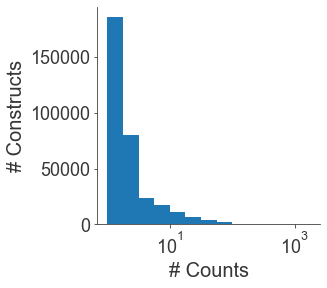

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
xVals = []
for tp in total_sgRNA_BC:
    for BC in BC_list:
        xVals += list(total_sgRNA_BC[tp][BC].values())
ax.hist(xVals, bins=[10**(x/4) for x in range(14)])
ax.set_xscale('log')
ax.set_xlabel('# Counts', fontsize=20)
ax.set_ylabel('# Constructs', fontsize=20)
plt.show()

In [7]:
full_sgRNA_list, filtered_sgRNA_list = [], []
for BC in BC_list:
    full_sgRNA_list += list(total_sgRNA_BC['T0'][BC].keys()) 
full_sgRNA_set = set(full_sgRNA_list)
for sgRNA in full_sgRNA_set:
    temp_BC_count = 0
    for BC in BC_list:
        if sgRNA in total_sgRNA_BC['T0'][BC]:
            if total_sgRNA_BC['T0'][BC][sgRNA] >= 5:
                temp_BC_count += 1
    if temp_BC_count >= 4:
        filtered_sgRNA_list.append(sgRNA)
print(f'Total sgRNAs (unfiltered): {len(full_sgRNA_set)}')
print(f'Total sgRNAs (filtered): {len(filtered_sgRNA_list)}')

Total sgRNAs (unfiltered): 40126
Total sgRNAs (filtered): 1004


### Calculate relative sgRNA frequency, calculate growth rates, and identify escapers

We first normalize raw counts by the nontargeting construct at each timepoint. Then we normalize relative frequencies at every timepoint by the relative frequency at $T_0$. For all constructs with counts present through the first three timepoints, we fit a line to $log_2$(relative frequency) vs. time data. The slope of this line is the construct's relative growth rate effect. Note: We won't normalize to generations here because we're using a separate rescaling factor later.

$relative frequency_{a,T}$ = $\frac{counts_{a,T} / counts_{Nont,T}}{counts_{a,T_0} / counts_{Nont,T_0}}$

Escapers are identified and removed using the Dixon q-test, as before.

In [8]:
gr_dict = {BC:{} for BC in BC_list}
norm_sgRNA = 'negC_rand_42-negC_rand_42-negC_rand_42'
for sgRNA in filtered_sgRNA_list:
    for BC in BC_list:
        temp_TPs, temp_counts = [], []
        for TP in total_sgRNA_BC:
            if sgRNA in total_sgRNA_BC[TP][BC]:
                temp_TPs.append(int(TP[1:]))
                temp_counts.append(np.log2(total_sgRNA_BC[TP][BC][sgRNA]/total_sgRNA_BC[TP][BC][norm_sgRNA])
                    - np.log2(total_sgRNA_BC['T0'][BC][sgRNA]/total_sgRNA_BC['T0'][BC][norm_sgRNA]))
            else:
                break
        if len(temp_TPs) >= 3:  # Require at least 3 timepoints to fit growth rates
            m, _, _, _, _ = stats.linregress(temp_TPs, temp_counts)
            gr_dict[BC][sgRNA] = m

In [9]:
gr_dict_mean, gr_dict_sem, tot_escapers = {}, {}, 0
for sgRNA in filtered_sgRNA_list:
    temp_gr = []
    for BC in gr_dict:
        if sgRNA in gr_dict[BC]:
            temp_gr.append(gr_dict[BC][sgRNA])
    if len(temp_gr) >= 4:
        filtered_gr, escaper = qtest_dixon(temp_gr)
        if ~np.isnan(escaper):
            tot_escapers += 1
        gr_dict_mean[sgRNA] = np.mean(filtered_gr)
        gr_dict_sem[sgRNA] = stats.sem(filtered_gr)

### Plot single- and pairwise knockdown growth rates relative to the pairwise only library

Separate competition assays will have distinct population doubling times, which will affect the rate of depletion or enrichment for different CRISPRi perturbations. As we hope to predict the growth rates for high-order perturbations in this library using dense, pairwise measurements from our previous data set, we must ensure that the single and pairwise perturbations present in both data sets are concordant. This is completed by assigning a rescaling constant to take relative growth rates from the third-order assay and normalize them *as if they were in the pairwise assay*.

In [10]:
gr_dict_mean_filt, gr_dict_sem_filt = {}, {}
for sgRNA in gr_dict_mean:
    sg1, sg2, sg3 = sgRNA.split('-')
    # As these sgRNA controls phenocopy one another, pool them under a single Nontargeting label
    if 'fake' in sg1:
        sg1 = 'negC_rand_42'
    if 'fake' in sg2:
        sg2 = 'negC_rand_42'
    if 'fake' in sg3:
        sg3 = 'negC_rand_42'
    if sg1 in off_target or sg2 in off_target or sg3 in off_target:  # Remove off-target sgRNAs
        continue
    new_sgRNA = f'{sg1}-{sg2}-{sg3}'
    if new_sgRNA in gr_dict_mean_filt:
        # This would only occur if two constructs were had identical targeting sgRNAs and different targeting sgRNAs
        print(f'{new_sgRNA} was repeated.')
    gr_dict_mean_filt[new_sgRNA] = gr_dict_mean[sgRNA]
    gr_dict_sem_filt[new_sgRNA] = gr_dict_sem[sgRNA]

In [11]:
targeting_count = {x:0 for x in range(4)}
for sgRNA in gr_dict_mean_filt:
    targeting = sum(['negC' not in sg for sg in sgRNA.split('-')])
    targeting_count[targeting] += 1
print(targeting_count)

{0: 1, 1: 4, 2: 76, 3: 830}


R2: 0.796
GR normalization constant: -0.946


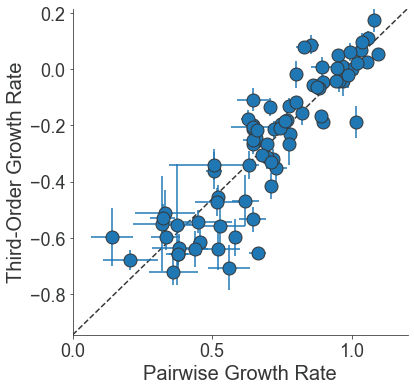

In [12]:
pairwise_gr, pairwise_sem, third_gr, third_sem = [], [], [], []
low_order = [sgRNA for sgRNA in gr_dict_mean_filt if 'negC' in sgRNA]
for sgRNA in low_order:
    sg = [x for x in sgRNA.split('-') if 'negC' not in x]  # Select targeting sgRNAs
    while len(sg) < 2:
        sg.append('negC_rand_42')  # Match pairwise formatting
    if sg[0] in pairwise_gr_rescale.index and sg[1] in pairwise_gr_rescale.index:
        third_gr.append(gr_dict_mean_filt[sgRNA])
        third_sem.append(gr_dict_sem_filt[sgRNA])
        if np.isnan(find_sgRNA_pair(pairwise_gr_rescale, sg[0], sg[1])):
            print(sg)
        pairwise_gr.append(find_sgRNA_pair(pairwise_gr_rescale, sg[0], sg[1]))
        pairwise_sem.append(find_sgRNA_pair(pairwise_sem_rescale, sg[0], sg[1]))
fig, ax = plt.subplots(figsize=(6, 6))
ax.errorbar(pairwise_gr, third_gr, xerr=pairwise_sem, yerr=third_sem, fmt='o', mec='xkcd:dark gray', ms=13)
m, gr_min, r, _, _ = stats.linregress(pairwise_gr, third_gr)
ax.plot([0, 1.2], [gr_min, 1.2*m+gr_min], ls='--', color='xkcd:dark gray', zorder=0)
ax.set_xlabel('Pairwise Growth Rate', fontsize=20)
ax.set_ylabel('Third-Order Growth Rate', fontsize=20)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2])
ax.set_xlim([0, 1.2])
ax.set_ylim([gr_min, 1.2*m+gr_min])
print(f'R2: {np.round(r**2, 3)}')
print(f'GR normalization constant: {np.round(gr_min, 3)}')
plt.show()

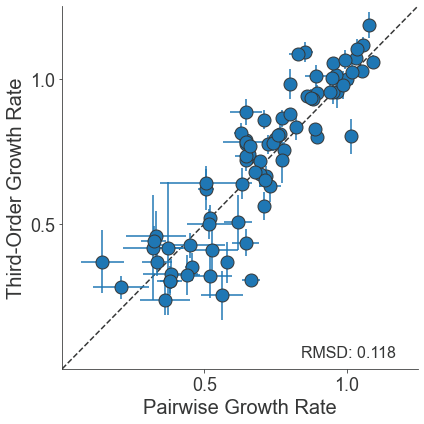

In [13]:
rescale_gr_vals, rescale_gr_sem = {}, {}
for sgRNA in gr_dict_mean_filt:
    rescale_gr_vals[sgRNA] = (gr_dict_mean_filt[sgRNA]-gr_min)/abs(gr_min)
    rescale_gr_sem[sgRNA] = gr_dict_sem_filt[sgRNA]/abs(gr_min)
third_gr_rescale = (third_gr-gr_min)/abs(gr_min)
third_sem_rescale = third_sem/abs(gr_min)
fig, ax = plt.subplots(figsize=(6, 6))
ax.errorbar(pairwise_gr, third_gr_rescale, xerr=pairwise_sem, yerr=third_sem_rescale, fmt='o', mec='xkcd:dark gray',
            ms=13)
ax.plot([0, 1.25], [0, 1.25], ls='--', color='xkcd:dark gray', zorder=0)
ax.text(0.84, 0.04, f'RMSD: {np.round(nanrms(np.array(pairwise_gr) - np.array(third_gr_rescale)), 3)}', fontsize=16)
ax.set_xlabel('Pairwise Growth Rate', fontsize=20)
ax.set_ylabel('Third-Order Growth Rate', fontsize=20)
ax.set_xticks([0.5, 1])
ax.set_yticks([0.5, 1])
ax.set_xlim([0, 1.25])
ax.set_ylim([0, 1.25])
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS6B.pdf')
plt.show()

### Predicting third-order growth rates

To predict growth rates of these third-order CRISPRi constructs, we need each sgRNA's repression intensity, which we extract from qPCR data. Then, we use these repression values, each gene's repression-growth rate function, and the relevant coupling constants to calculate effective repression values for each perturbation. Finally, we combine these to calculate a predicted growth rate following each perturbation. This is completed for each bootstrapped set of coupling constants and the coupling constants fit on the original pairwise data set.

In [14]:
gr_trip_dict, gr_null_dict = {boot_it:{} for boot_it in pair_avals}, {boot_it:{} for boot_it in pair_avals}
for full_sgRNA in rescale_gr_vals:
    sp = full_sgRNA.split('-')
    genes = [x.split('_')[0] for x in sp]
    if len(set(genes)) == 3 and 'negC' not in full_sgRNA:
        for boot_it in pair_avals:
            avals_list = []
            for subset in itertools.combinations(genes, 2):  # All pairwise combinations
                if (subset[0], subset[1]) in pair_avals[boot_it]:  # This logic corrects for gene order
                    avals_list += list(pair_avals[boot_it][(subset[0], subset[1])])
                else:
                    avals_list += list(pair_avals[boot_it][(subset[1], subset[0])])
            repression_list, params = [], []
            for i, gene in enumerate(genes):
                repression_list.append([qPCR_vals[gene][sp[i]]])
                params.append(list(hill_elements[boot_it][gene]))
            gr_list = third_order_gr(avals_list, repression_list, params)
            gr_list_null = third_order_gr(np.array([0, 0, 0, 0, 0, 0]), repression_list, params)
            gr_trip_dict[boot_it][full_sgRNA] = gr_list[-1][0][0][0]
            gr_null_dict[boot_it][full_sgRNA] = gr_list_null[-1][0][0][0]
gr_trip_std, gr_null_std = {}, {}
for sgRNA in gr_trip_dict['Full Fit']:
    gr_trip_std[sgRNA] = np.std([gr_trip_dict[boot_it][sgRNA] for boot_it in gr_trip_dict if boot_it != 'Full Fit'])
    gr_null_std[sgRNA] = np.std([gr_trip_dict[boot_it][sgRNA] for boot_it in gr_trip_dict if boot_it != 'Full Fit'])

### Identify epistatic constructs and plot model performance, subdivided by epistatic strength and direction.

Third-order CRISPRi constructs with strong pairwise epistasis are tagged as "Epistatic" constructs. This is done using a two-step approach.
Step 1: Identify gene pairs with strong pairwise epistasis. These gene pairs have at least one coupling constant with a magnitude greater than an empirically determined cutoff. The results of future analysis are largely insensitive to the exact value of this cutoff.
Step 2: Identify CRISPRi constructs with potentially strong epistasis. These constructs contain an sgRNA pair targeting both genes within an epistatic gene pair with fewer than 9 mismatches in the sgRNA homology region. This mismatch cutoff is important, as sgRNAs with 10-14 mismatches are generally nonepistatic and don't strongly affect growth. Slight changes to this cutoff are tolerated (±1 mismatch).

Model performance for the continuous epistasis and Null models (both trained on data from our pairwise CRISPRi experiment) is plotted, with labels corresponding to the epistatic strength and direction for each CRISPRi construct. Both models underestimate growth rate near wildtype, as these minor perturbations seem to combine sub-additively. When we approach a more severe growth rate regime (where ~75% of the data lie), the Null model continues underestimating growth rate -- especially for postively epistatic constructs. The continuous epistasis model, however, much more accurately predicts these growth rates. The performance of the continuous epistasis model is not hindered by the presence or absence of pairwise epistasis, and no obvious third-order epistatic interaction emerged.

In [15]:
positive_pairs, negative_pairs, epi_cutoff = [], [], 0.15
for gene_pair, avals in pair_avals['Full Fit'].items():
    if avals[0] > epi_cutoff or avals[1] > epi_cutoff:
        positive_pairs.append(gene_pair)
    if avals[0] < -epi_cutoff or avals[1] < -epi_cutoff:
        negative_pairs.append(gene_pair)
print(f'Positively epistatic gene pairs: {positive_pairs}')
print(f'Negatively epistatic gene pairs: {negative_pairs}')

Positively epistatic gene pairs: [('dapA', 'dapB'), ('dapA', 'purN'), ('dapB', 'purN')]
Negatively epistatic gene pairs: [('gdhA', 'gltB')]


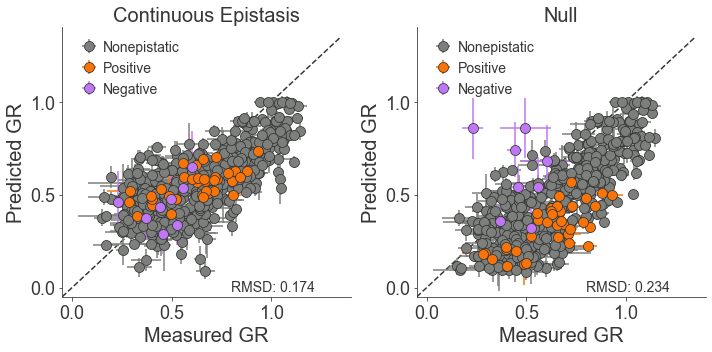

In [16]:
exp_gr, exp_sem, epi_pred, epi_std, null_pred, null_std = {}, {}, {}, {}, {}, {}
full_exp, full_epi, full_null = [], [], []
label_dict = {'xkcd:medium gray':'Nonepistatic', 'xkcd:orange': 'Positive', 'xkcd:light purple':'Negative'}
cutoff = 9
for color in ['xkcd:medium gray', 'xkcd:orange', 'xkcd:light purple']:
    exp_gr[color], exp_sem[color], epi_pred[color], epi_std[color], null_pred[color], null_std[color] = [], [], [], \
                                                                                                       [], [], []
for sgRNA, exp_val in rescale_gr_vals.items():
    if sgRNA in gr_trip_dict['Full Fit']:
        color = 'xkcd:medium gray'
        # In this study, third-order sgRNAs cannot have both positive and negative pairwise epistasis
        for gene_pair in positive_pairs:
            if test_epistatic(sgRNA, gene_pair[0], gene_pair[1], cutoff):
                color = 'xkcd:orange'
        for gene_pair in negative_pairs:
            if test_epistatic(sgRNA, gene_pair[0], gene_pair[1], cutoff):
                color = 'xkcd:light purple'
        exp_gr[color].append(exp_val)
        exp_sem[color].append(rescale_gr_sem[sgRNA])
        epi_pred[color].append(gr_trip_dict['Full Fit'][sgRNA])
        null_pred[color].append(gr_null_dict['Full Fit'][sgRNA])
        epi_std[color].append(gr_trip_std[sgRNA])
        null_std[color].append(gr_null_std[sgRNA])
        full_exp.append(exp_val)
        full_epi.append(gr_trip_dict['Full Fit'][sgRNA])
        full_null.append(gr_null_dict['Full Fit'][sgRNA])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for color in exp_gr:
    ax[0].errorbar(exp_gr[color], epi_pred[color], xerr=exp_sem[color], yerr=epi_std[color], fmt='o', ms=10,
                   color=color, mew=0.8, label=label_dict[color], mec='xkcd:dark gray')
    ax[1].errorbar(exp_gr[color], null_pred[color], xerr=exp_sem[color], yerr=null_std[color], fmt='o', ms=10,
                   color=color, mew=0.8, label=label_dict[color], mec='xkcd:dark gray')
ax[0].text(0.8, -0.02, f'RMSD: {np.round(nanrms(np.array(list(full_epi))-list(full_exp)), 3)}', fontsize=14)
ax[1].text(0.8, -0.02, f'RMSD: {np.round(nanrms(np.array(list(full_null))-list(full_exp)), 3)}', fontsize=14)
for i in [0, 1]:
    ax[i].set_xlim([-0.05, 1.4])
    ax[i].set_ylim([-0.05, 1.4])
    ax[i].set_xticks([0, 0.5, 1])
    ax[i].set_yticks([0, 0.5, 1])
    ax[i].plot([-0.05, 1.35], [-0.05, 1.35], ls='--', color='xkcd:dark gray', zorder=0)
    ax[i].set_xlabel('Measured GR', fontsize=20)
    ax[i].set_ylabel('Predicted GR', fontsize=20)
    ax[i].legend()
ax[0].set_title('Continuous Epistasis', fontsize=20)
ax[1].set_title('Null', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/Fig5C-D.pdf')
plt.show()

### Compare the continuous epistasis model with alternative high-order models

The Isserlis and Regression models can also predict high-order phenotypes from low-order data, although they have two limitations compared to our continuous epistasis model. (i) These models are discrete, meaning they require a distinct set of low-order perturbations (all single- and pairwise combinations of perturbations of interest) to predict a high-order phenotype. This means they also cannot interpolate or extrapolate. (ii) These models, while often able to predict the effects of pairwise epistasis, do not provide insight into the sign or strength of these epistatic interactions, making them far less interpretable.

We use a "smoothed" version of the Isserlis and Regression models (see Zimmer et al.) to better compare our model to these alternative ones, although they still remain less interpretable than the continuous epistasis model. The Regression model is highly sensitive to experimental noise and performs significantly worse than the other two models. The improvements in the Isserlis model's RMSD mainly stem from improved accuracy near wildtype-like growth.

In [17]:
gr_isserlis_dict, std_isserlis_dict, gr_regression_dict, std_regression_dict = {}, {}, {}, {}
for sgRNA in rescale_gr_vals:
    sp = sgRNA.split('-')
    sg1, sg2, sg3 = sp
    genes = [x.split('_')[0] for x in sp]
    if len(set(genes)) == 3 and 'negC' not in sgRNA:
        if sp[0] in pairwise_gr_rescale.index and sp[1] in pairwise_gr_rescale.index \
        and sp[2] in pairwise_gr_rescale.index:
            with warnings.catch_warnings():  # Runtime warning expected when pairwise data is missing
                warnings.simplefilter('ignore', category=RuntimeWarning)
                sg1_GR = find_sgRNA_pair(pairwise_gr_rescale, sg1)
                sg1_std = find_sgRNA_pair(pairwise_sem_rescale, sg1)
                sg2_GR = find_sgRNA_pair(pairwise_gr_rescale, sg2)
                sg2_std = find_sgRNA_pair(pairwise_sem_rescale, sg2)
                sg3_GR = find_sgRNA_pair(pairwise_gr_rescale, sg3)
                sg3_std = find_sgRNA_pair(pairwise_sem_rescale, sg3)
                sg12_GR = find_sgRNA_pair(pairwise_gr_rescale, sg1, sg2)
                sg12_std = find_sgRNA_pair(pairwise_sem_rescale, sg1, sg2)
                sg13_GR = find_sgRNA_pair(pairwise_gr_rescale, sg1, sg3)
                sg13_std = find_sgRNA_pair(pairwise_sem_rescale, sg1, sg3)
                sg23_GR = find_sgRNA_pair(pairwise_gr_rescale, sg2, sg3)
                sg23_std = find_sgRNA_pair(pairwise_sem_rescale, sg2, sg3)
                gr_isserlis_dict[sgRNA] = sg12_GR*sg3_GR + sg13_GR*sg2_GR + sg23_GR*sg1_GR - 2*sg1_GR*sg2_GR*sg3_GR
                std_isserlis_dict[sgRNA] = np.sqrt((sg12_GR*sg3_GR*np.sqrt((sg12_std/sg12_GR)**2 \
                                        + (sg3_std/sg3_GR)**2))**2
                                        + (sg13_GR*sg2_GR*np.sqrt((sg13_std/sg13_GR)**2 + (sg2_std/sg2_GR)**2))**2
                                        + (sg23_GR*sg1_GR*np.sqrt((sg23_std/sg23_GR)**2 + (sg1_std/sg1_GR)**2))**2
                                        + 2*sg1_GR*sg2_GR*sg3_GR
                                        * np.sqrt((sg1_std/sg1_GR)**2 + (sg2_std/sg2_GR)**2 + (sg3_std/sg3_GR)**2)**2)
                gr_regression_dict[sgRNA] = sg12_GR*sg13_GR*sg23_GR / (sg1_GR*sg2_GR*sg3_GR)
                std_regression_dict[sgRNA] = gr_regression_dict[sgRNA] \
                                     * np.sqrt((sg12_std/sg12_GR)**2 + (sg13_std/sg13_GR)**2 + (sg23_std/sg23_GR)**2
                                     + (sg1_std/sg1_GR)**2 + (sg2_std/sg2_GR)**2 + (sg3_std/sg3_GR)**2)

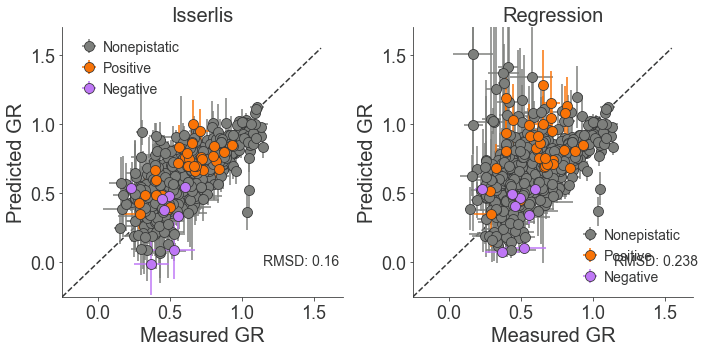

In [18]:
exp_gr, exp_sem, epi_pred, epi_std, null_pred, null_std = {}, {}, {}, {}, {}, {}
full_exp, full_epi, full_null = [], [], []
label_dict = {'xkcd:medium gray':'Nonepistatic', 'xkcd:orange': 'Positive', 'xkcd:light purple':'Negative'}
cutoff = 9
for color in ['xkcd:medium gray', 'xkcd:orange', 'xkcd:light purple']:
    exp_gr[color], exp_sem[color], epi_pred[color], epi_std[color], null_pred[color], null_std[color] = [], [], [], \
                                                                                                       [], [], []
for sgRNA, exp_val in rescale_gr_vals.items():
    if sgRNA in gr_isserlis_dict:
        color = 'xkcd:medium gray'
        # In this study, third-order sgRNAs cannot have both positive and negative pairwise epistasis
        for gene_pair in positive_pairs:
            if test_epistatic(sgRNA, gene_pair[0], gene_pair[1], cutoff):
                color = 'xkcd:orange'
        for gene_pair in negative_pairs:
            if test_epistatic(sgRNA, gene_pair[0], gene_pair[1], cutoff):
                color = 'xkcd:light purple'
        exp_gr[color].append(exp_val)
        exp_sem[color].append(rescale_gr_sem[sgRNA])
        epi_pred[color].append(gr_isserlis_dict[sgRNA])
        null_pred[color].append(gr_regression_dict[sgRNA])
        epi_std[color].append(std_isserlis_dict[sgRNA])
        null_std[color].append(std_regression_dict[sgRNA])
        full_exp.append(exp_val)
        full_epi.append(gr_isserlis_dict[sgRNA])
        full_null.append(gr_regression_dict[sgRNA])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for color in exp_gr:
    ax[0].errorbar(exp_gr[color], epi_pred[color], xerr=exp_sem[color], yerr=epi_std[color], fmt='o', ms=10,
                   color=color, mew=0.8, label=label_dict[color], mec='xkcd:dark gray')
    ax[1].errorbar(exp_gr[color], null_pred[color], xerr=exp_sem[color], yerr=null_std[color], fmt='o', ms=10,
                   color=color, mew=0.8, label=label_dict[color], mec='xkcd:dark gray')
ax[0].text(1.15, -0.02, f'RMSD: {np.round(nanrms(np.array(list(full_epi))-list(full_exp)), 3)}', fontsize=14)
ax[1].text(1.15, -0.02, f'RMSD: {np.round(nanrms(np.array(list(full_null))-list(full_exp)), 3)}', fontsize=14)
for i in [0, 1]:
    ax[i].set_xlim([-0.25, 1.7])
    ax[i].set_ylim([-0.25, 1.7])
    ax[i].set_xticks([0, 0.5, 1, 1.5])
    ax[i].set_yticks([0, 0.5, 1, 1.5])
    ax[i].plot([-0.25, 1.55], [-0.25, 1.55], ls='--', color='xkcd:dark gray', zorder=0)
    ax[i].set_xlabel('Measured GR', fontsize=20)
    ax[i].set_ylabel('Predicted GR', fontsize=20)
    ax[i].legend()
ax[0].set_title('Isserlis', fontsize=20)
ax[1].set_title('Regression', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS6C-D.pdf')
plt.show()

### Generate tables

In [19]:
table_e3 = pd.DataFrame(np.full((len(rescale_gr_vals), 7), np.nan), columns=['sgRNA1', 'sgRNA2', 'sgRNA3',
                                            'Growth Rate', 'Growth Rate SEM', 'Model Prediction', 'Null Prediction'])
for i, full_sgRNA in enumerate(rescale_gr_vals):
    sgRNA_split = full_sgRNA.split('-')
    if full_sgRNA in gr_trip_dict['Full Fit']:
        temp_triple = gr_trip_dict['Full Fit'][full_sgRNA]
        temp_null = gr_null_dict['Full Fit'][full_sgRNA]
    else:
        temp_triple, temp_null = 'N/A', 'N/A'
    table_e3.loc[i] = [sgRNA_split[0], sgRNA_split[1], sgRNA_split[2], rescale_gr_vals[full_sgRNA],
                       rescale_gr_sem[full_sgRNA], temp_triple, temp_null]
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_e3.to_excel(writer, sheet_name='Table Extra3')